# CSCI 4962 Homework 2
Ethan Cruz

September 16, 2022

In [10]:
# Imports
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split as TTSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from sklearn import ensemble

## Task 1:
Last problem I tried to solve: **"The best mix of defense and offense to win basketball games"**. I used one parameter: Offensive Efficiency Rating minus Defensive Efficiency Rating. Now I'll use OER and DER as 2 seperate variables to attempt to improve accuracy. Also if there was only one variable, the decision tree would be small.

Let's reform our dataset:

<AxesSubplot:xlabel='OER', ylabel='DER'>

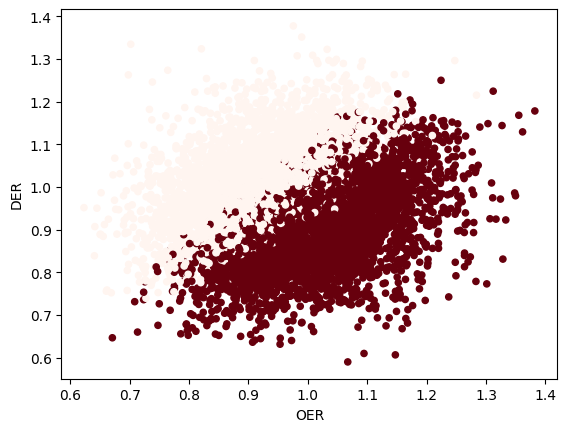

In [2]:
""" Offensive Efficiency Rating formula
    PTS = Points scored by your team
    FGA = Field goals attempted by your team
    FTA = Free throws attempted by your team
    TOV = Turnovers by your team
"""
def getOER(PTS, FGA, FTA, TOV):
    return PTS / (FGA + ((FTA*0.9)/2) + TOV)

df = pd.read_csv('basketball.csv')
df = df.dropna()
df = df.drop(df.index[0:(len(df) - 8000)])
# At this point, df = the latest 8000 games. Let's now use OEG formula to get our Effective Rating values
OER = getOER(df['PTS_HOME'], df['FGA_HOME'], df['FTA_HOME'], df['TOV_HOME'])
DER = getOER(df['PTS_AWAY'], df['FGA_AWAY'], df['FTA_AWAY'], df['TOV_AWAY'])
df2 = pd.DataFrame()
target = [(0,1)[ord(str(wl)[0]) > 80] for wl in df['WL_HOME']]
df2['OER'] = [oer for oer in OER]
df2['DER'] = [der for der in DER]
df2.plot.scatter(x='OER', y='DER', c=target, cmap='Reds')
# Red = 1, Pink = 0. Low DER is good. High OER is good.

Now with our new dataset, the next move is to try a Decision tree. I am going to be using the scikit learn's Decision Tree Classifier.

I am going to try a couple trees of varying sizes. First, a depth of 2 (practically a perceptron splitting the data only twice). The idea is that this would be one split for OER and one split for DER total. Next, I want to try with no max depth to see how far the accuracy can go.

In [16]:
data = df2.to_numpy()
datTarget = np.array(target)

# Train is 7000 games, Test is 500 games.
XTrain, XTest, YTrain, YTest = TTSplit(data,datTarget,random_state = 500)

# Our trees
clfTwo = DTC(max_depth=2,random_state=7)
clfFour = DTC(max_depth=4,random_state=7)
clfEight = DTC(max_depth=8,random_state=7)
clfNoMax = DTC(random_state=7)

# K-fold cross validation (k = 7, so each batch is ~1000 samples)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=5, random_state=7)
twoScores = cross_val_score(clfTwo, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')
fourScores = cross_val_score(clfFour, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')
eightScores = cross_val_score(clfEight, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')
noMaxScores = cross_val_score(clfNoMax, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')

# Print accuracies
print("Decision Tree Classifier accuracies & standard deviation: ")
print("Tree depth = 2 acc: ", np.mean(twoScores), " & std: ", np.std(twoScores))
print("Tree depth = 4 acc: ", np.mean(fourScores), " & std: ", np.std(fourScores))
print("Tree depth = 8 acc: ", np.mean(eightScores), " & std: ", np.std(eightScores))
print("No max tree depth acc: ", np.mean(noMaxScores), " & std: ", np.std(noMaxScores))

Decision Tree Classifier accuracies & standard deviation: 
Tree depth = 2 acc:  0.8227665760921303  & std:  0.012958707138099287
Tree depth = 4 acc:  0.8911999319233858  & std:  0.010321447308685701
Tree depth = 8 acc:  0.8880668534110774  & std:  0.009574113049963588
No max tree depth acc:  0.860700326511295  & std:  0.00985388021826684


Not surprisingly, as we increase depth the accuracy increases. Increasing depth means there is more steps meaning more fitting to the train data. Of course, this can lead to overfitting, but at such a low depth it doesn't seem to affect our test accuracy too much. **BUT** when the depth has no max, overfitting occurs, and our accuracy goes down.

Here are the plots of train data

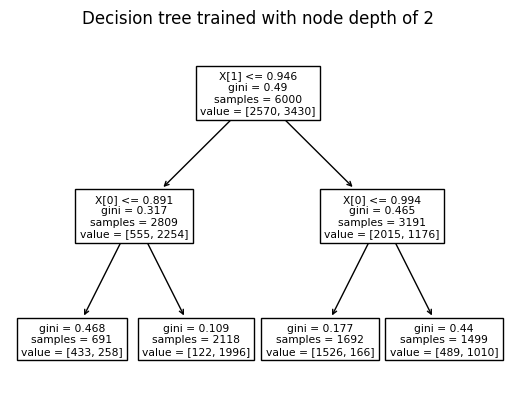

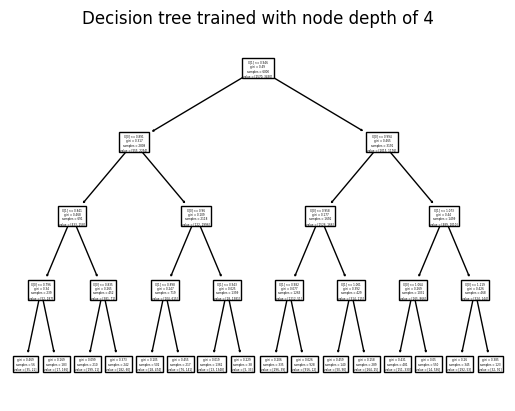

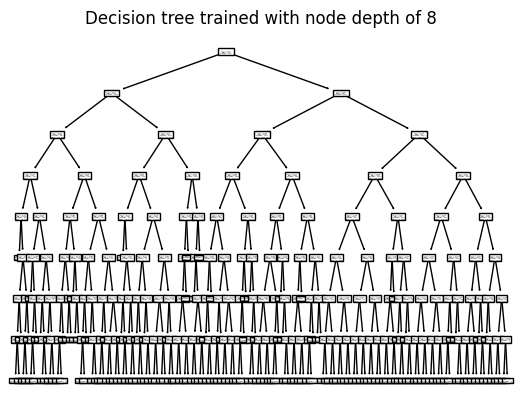

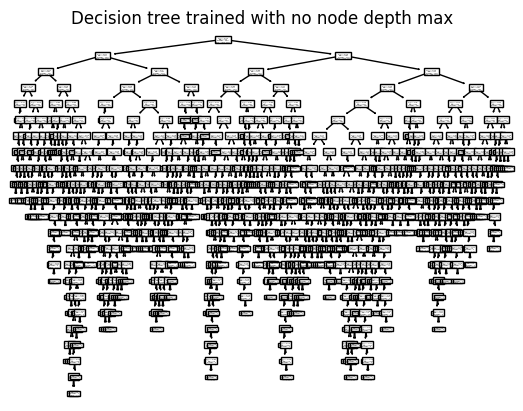

In [4]:
# Displaying  data
plt.figure()
tree.plot_tree(clfTwo)
plt.title("Decision tree trained with node depth of 2")
plt.show()

plt.figure()
tree.plot_tree(clfFour)
plt.title("Decision tree trained with node depth of 4")
plt.show()

plt.figure()
tree.plot_tree(clfEight)
plt.title("Decision tree trained with node depth of 8")
plt.show()

plt.figure()
tree.plot_tree(clfNoMax)
plt.title("Decision tree trained with no node depth max")
plt.show()

The fitting becomes more and more dangerous as the node depth increases. This is much more obvious with four vs eight vs noMax. The number of decisions quickly becomes rediculous!

## Task 2:
The next step is one bagging and one boosting method. Since we did decision tree in the beginning it would be helpful to use trees as the algorithm for this part as well, to compare easier. For this reason, I will be doing a random forest classifier and gradient boosting classifier.

In [15]:
# data is XTrain, XTest, YTrain, YTest

# Random Trees
RTClf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=2, random_state=7)

# Gradient Boosting
GBClf = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=7)

# Instead of just checking accuracy, we do k-fold CV. (k = 7 so groups of ~1000 data points each)
RTScores = cross_val_score(RTClf, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')
GBScores = cross_val_score(GBClf, XTrain, YTrain, scoring='accuracy', cv=cv, error_score='raise')

# Print accuracies
print("Bagging/Boosting methods accuracies & standard deviation: ")
print("Random Forest 100 trees, depth 2 acc: ", np.mean(RTScores), " & std: ", np.std(RTScores))
print("Gradient Boosting Classifier 100 trees, depth 2 acc: ", np.mean(GBScores), " & std: ", np.std(GBScores))

Bagging/Boosting methods accuracies & standard deviation: 
Random Forest 100 trees, depth 2 acc:  0.8769331407604454  & std:  0.012668036473161724
Gradient Boosting Classifier 100 trees, depth 2 acc:  0.9041333617763023  & std:  0.008633308074038152


I'll get to comparing the outputs to the trees in part 1 for later. For now, lets discuss the differences in the two methods here.

The most obvious difference would be the iterative property of Gradient Boosting. While Random Forest is merely a collection of classifiers, GB builds off of each tree's guess to create the next one. This improves GB's ability to fit the training data. Meanwhile, RF is an aggregate score which is harder to fit well.

This conversation leads right into overfitting, which I believe to be the biggest factor in **ALL** the classifiers this homework. So let's talk about it in part 3:

## Task 3

The most important metric is overfitting. Each method can be highly accurate, within a few percents of eachother. I have no doubts the noMax tree probably fit the training data to near 100% accuracy, but it suffered incredibly with the test set. This is because it overfit the train data, causing it to fail to all the other trees (except depth = 2). 

It's explainable why the depth = 4 and depth = 8 trees beat noMax. They have less steps and were selected at those depths because I knew there were only 2 variables for data. On the other hand, the noMax could keep increasing in depth until the entire train set was fit.

But what about random forest and gradient boosting? They beat noMax because they both have built-in regularization.

The random forest is practically a bunch of underfit trees (not unlike depth = 2 tree) strung together to give an accurate output. Meanwhile, the gradient boosting classifier has a learning rate which prevents too many variables from having a strong influence on the prediction. 

Overfitting is the correct metric to choose because of how interwoven the data is. Looking back at the original scatterplot, the win and loss prediction is a matter of chance when OER and DER are close to equal. This means an overfit predictor will have a hard time correctly guessing if it only looks at it's training set.

With such a muddled dataset, a well regularized (but not underfit!) predictor would come out with a high accuracy and a low standard deviation. The best predictors are GB, RF, and Decision Tree Depth = 4

A different metric I could chose is **simplicity**. Some may say simple is better, and with a small set of variables (just OER and DER) the predictor does not need to be very fancy. With this idea in mind, the best predictors would be RF, Decision Tree Depth = 2 and Decision Tree Depth = 4.

This is because RF is not unlike k-NN in simplicity and the smaller decision trees are simple in design. If I was going for simplicity, linear regression might even be the best predictor. A simple projection matrix, one line of code, could solve this data with ease!

Of course, choosing a predictor of simplicity might mean my accuracy will take a hit. Although, as depth = 4 has an accuracy of 89%, I don't think it would.